In [2]:
# cell 1

import awkward as ak
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import hist
from hist import Hist
import mplhep as hep
hep.style.use(hep.style.CMS)

The nice thing of having `.parquet` trees as output is that they are really easy to manipulate with python using `awkward` and `numpy`.

First we load the MC and data samples, this is achieved using awkward, which unpack the `.parquet` HiggsDNA NTuple in a jagged array.

In [3]:
# cell 2

# Load the data
data_arr = ak.from_parquet('03_NTuples/DataC_2022/nominal/')

# Load MC samples
MC_dict = {}
variations = ['nominal','Smearing_down','Smearing_up']
for variation in variations:
    MC_dict[f'DY_{variation}_arr'] = ak.from_parquet(f'03_NTuples/DY/{variation}/')

In [4]:
# cell 3

MC_dict

{'DY_nominal_arr': <Array [{tag_seediEtaOriX: 26, ... ] type='63336 * {"tag_seediEtaOriX": ?int8, "...'>,
 'DY_Smearing_down_arr': <Array [{tag_seediEtaOriX: 26, ... ] type='63345 * {"tag_seediEtaOriX": ?int8, "...'>,
 'DY_Smearing_up_arr': <Array [{tag_seediEtaOriX: 26, ... ] type='63351 * {"tag_seediEtaOriX": ?int8, "...'>}

# Plotting distributions
We now define the directory for plots

In [5]:
# cell 4

# directory for output plots
plots_dir = './plots'
Path(plots_dir).mkdir(exist_ok=True)

## Mass plot

We then create a mass histograms starting from our data and MC arrays

### Define some useful functions

In [6]:
# cell 5

def align_arr_edge(old_arr, old_edges):
    assert len(old_edges) == len(old_arr) + 1
    new_arr, new_edges = [], []
    for i, val in enumerate(old_arr):
        new_arr.append(val)
        new_arr.append(val)
        new_edges.append(old_edges[i])
        new_edges.append(old_edges[i + 1])
    return new_arr, new_edges

def get_ratio(plt_numerator, plt_denominator):
    val_num = plt_numerator.values()
    var_num = plt_numerator.variances()
    val_denom = plt_denominator.values()
    var_denom = plt_denominator.variances()

    ratio_val_num = val_num / val_denom
    ratio_val_num = np.clip(ak.nan_to_num(ratio_val_num, nan=1), -9999.0, 9999.0)
    # error calculation
    ratio_err_num = np.sqrt(var_num) / val_denom
    ratio_err_num = np.clip(ak.nan_to_num(ratio_err_num, nan=1), -9999.0, 9999.0)

    return ratio_val_num, ratio_err_num


### Data/MC comparison

Let us compare Data/MC **without** the systematic uncertainty, only the statistical uncertainty. We will also add ratio plot.

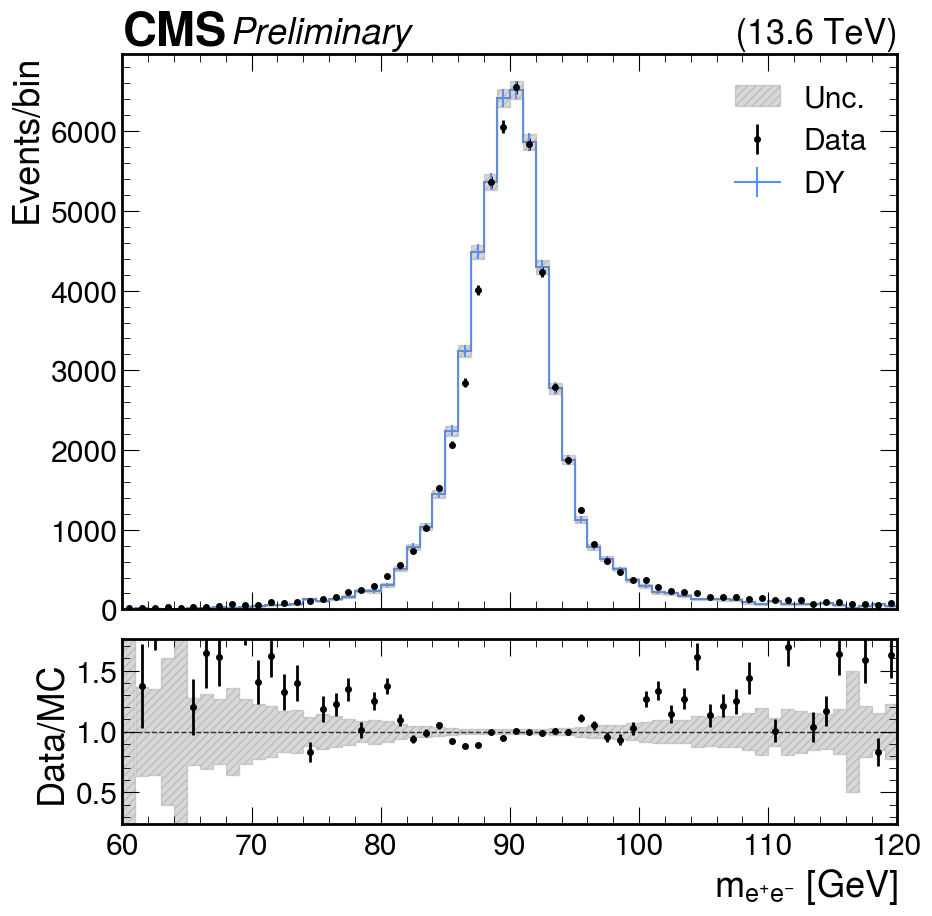

In [7]:
# cell 6

# create the axes
f, ax = plt.subplots(
    2, 1, gridspec_kw=dict(height_ratios=[3, 1], hspace=0.08), sharex=True
)

# define the histogram
n_bins = 60
x_low = 60
x_high = 120

h_data = (
    Hist.new.Reg(n_bins, x_low, x_high, overflow=False, underflow=False, name=r"m$_{e^{+} e^{-}}$ [GeV]")
    .Weight()
)
h_mc = (
    Hist.new.Reg(n_bins, x_low, x_high, overflow=False, underflow=False, name=r"m$_{e^{+} e^{-}}$ [GeV]")
    .Weight()
)

# Filling histogram
h_data.fill(data_arr.mass)
h_mc.fill(MC_dict['DY_nominal_arr'].mass,weight=MC_dict['DY_nominal_arr'].weight)
## We focus on comparing the shape of the Data & MC
## So we will normalize the MC to Data
## Normalize factor
norm_factor = h_data.sum().value/h_mc.sum().value
h_mc*=norm_factor

# Plotting
## We care more about the distribution shapes
## So we set the density to be true
h_data.plot(label="Data",
            histtype="errorbar",
            marker="o",
            markersize=4,
            elinewidth=2,
            color="black",
            ax=ax[0])
h_mc.plot(label="DY",ax=ax[0])

# plotting MC uncertainty band
xaxis_edges = h_mc.axes.edges[0]

val_num = h_mc.values()
var_num = h_mc.variances()

val_up, new_xedges = align_arr_edge(val_num+np.sqrt(var_num),xaxis_edges)
val_down, new_xedges = align_arr_edge(val_num-np.sqrt(var_num),xaxis_edges)

ax[0].fill_between(
    new_xedges,
    val_up,
    val_down,
    alpha=0.3,
    color="gray",
    hatch="////",
    label=r"Unc.",
)

# Ratio plot
## we use a simple function to calculate the ratio between the numerator and denominator
## ratio_value: numerator/denominator
## ratio_err: numerator_err/denominator

### ratio between Data and MC
ratio_val_data, ratio_err_data = get_ratio(plt_numerator=h_data,plt_denominator=h_mc)
hep.histplot(
    ratio_val_data,
    bins=xaxis_edges,
    # label=f"{dataset}/{denom_name}",
    yerr=np.abs(ratio_err_data),
    histtype="errorbar",
    stack=False,
    color="black",
    ax=ax[1],
    marker="o",
    markersize=4,
    elinewidth=2,
)

### Get uncertainty band of MC
ratio_val_mc, ratio_err_mc = get_ratio(plt_numerator=h_mc,plt_denominator=h_mc)
ratio_val_up_mc, new_xedges = align_arr_edge(ratio_val_mc+ratio_err_mc,xaxis_edges)
ratio_val_down_mc, new_xedges = align_arr_edge(ratio_val_mc-ratio_err_mc,xaxis_edges)
ax[1].fill_between(
    new_xedges,
    ratio_val_up_mc,
    ratio_val_down_mc,
    alpha=0.3,
    color="gray",
    hatch="////"
)
ax[1].axhline(y=1, linestyle="--", color="k", linewidth=1, alpha=0.8)

# Styling
ax[0].set_ylabel('Events/bin')
ax[1].set_xlabel(ax[0].get_xlabel())
ax[0].set_xlabel("")
ax[1].set_ylabel("Data/MC",loc="center")
ax[0].legend()
ax[0].set_xlim(x_low, x_high)
ax[0].set_ylim(bottom=0)
ax[1].set_ylim(0.24,1.76)

hep.cms.label("Preliminary",loc=0,com=13.6,data=True,ax=ax[0])
plt.savefig(f'{plots_dir}/zee_mass.png', bbox_inches="tight")

#### Question

Is the agreement between Data and MC better after considering the smearing correction?

### Data/MC nominal comparison

Let us compare Data/MC **with** the systematic uncertainty. We will also add ratio plot.

For visualization, the total error is the square root of the quadratic sum of all systematic and statistical uncertainties, i.e.,

$\sigma_{\mathrm{tot}} = \sqrt{\sum_{i}{(\sigma_{\mathrm{systematic}}^{i}})^{2}+(\sigma_{\mathrm{statistical}})^{2}}$


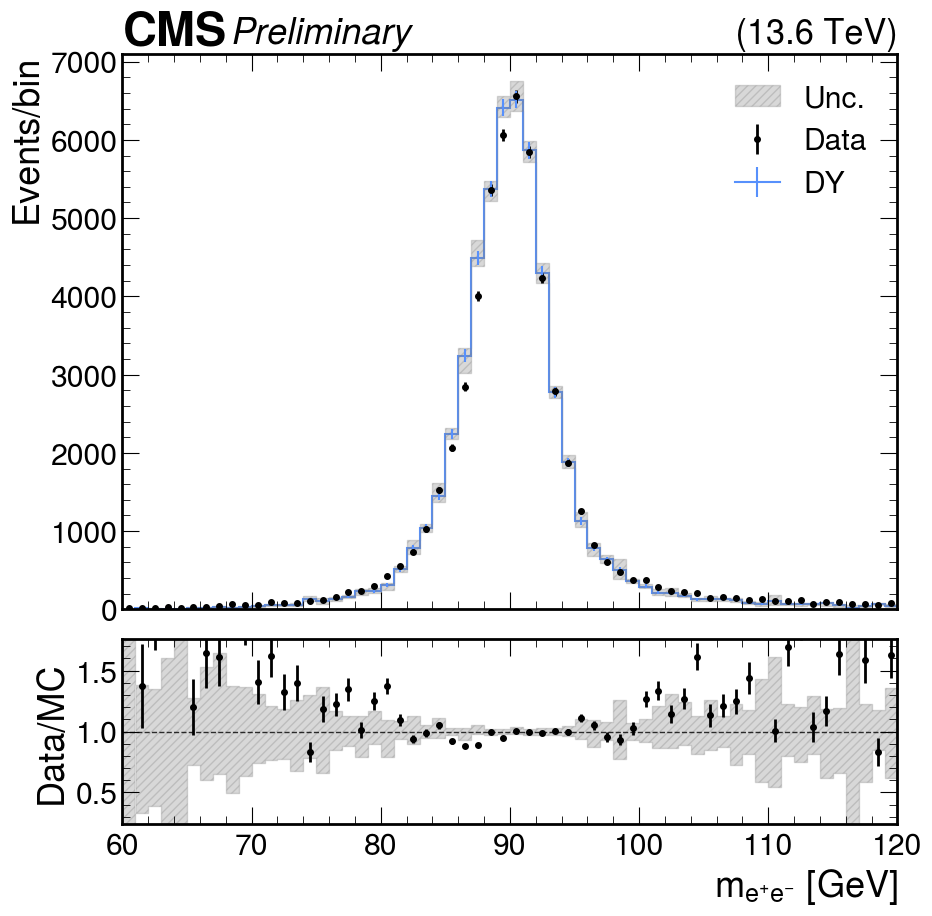

In [9]:
# cell 7

# create the axes
f, ax = plt.subplots(
    2, 1, gridspec_kw=dict(height_ratios=[3, 1], hspace=0.08), sharex=True
)

# define the histogram
n_bins = 60
x_low = 60
x_high = 120

h_data = (
    Hist.new.Reg(n_bins, x_low, x_high, overflow=False, underflow=False, name=r"m$_{e^{+} e^{-}}$ [GeV]")
    .Weight()
)
h_mc = (
    Hist.new.Reg(n_bins, x_low, x_high, overflow=False, underflow=False, name=r"m$_{e^{+} e^{-}}$ [GeV]")
    .Weight()
)
# ! new
h_mc_up = (
    Hist.new.Reg(n_bins, x_low, x_high, overflow=False, underflow=False, name=r"m$_{e^{+} e^{-}}$ [GeV]")
    .Weight()
)
h_mc_down = (
    Hist.new.Reg(n_bins, x_low, x_high, overflow=False, underflow=False, name=r"m$_{e^{+} e^{-}}$ [GeV]")
    .Weight()
)

# Filling histogram
h_data.fill(data_arr.mass)
h_mc.fill(MC_dict['DY_nominal_arr'].mass,weight=MC_dict['DY_nominal_arr'].weight)
# ! new
h_mc_up.fill(MC_dict['DY_Smearing_up_arr'].mass,weight=MC_dict['DY_Smearing_up_arr'].weight)
h_mc_down.fill(MC_dict['DY_Smearing_down_arr'].mass,weight=MC_dict['DY_Smearing_down_arr'].weight)
## We focus on comparing the shape of the Data & MC
## So we will normalize the MC to Data
## Normalize factor
norm_factor = h_data.sum().value/h_mc.sum().value
h_mc*=norm_factor
# ! new
h_mc_up*=norm_factor
h_mc_down*=norm_factor

# Plotting
## We care more about the distribution shapes
## So we set the density to be true
h_data.plot(label="Data",
            histtype="errorbar",
            marker="o",
            markersize=4,
            elinewidth=2,
            color="black",
            ax=ax[0])
h_mc.plot(label="DY",ax=ax[0])

# plotting MC uncertainty band
xaxis_edges = h_mc.axes.edges[0]

val_num = h_mc.values()
var_num = h_mc.variances()

# ! new: stat+syst
var_up_num = var_num+np.power(h_mc_up.values()-h_mc.values(),2)
var_down_num = var_num+np.power(h_mc_down.values()-h_mc.values(),2)
val_up, new_xedges = align_arr_edge(val_num+np.sqrt(var_up_num),xaxis_edges)
val_down, new_xedges = align_arr_edge(val_num-np.sqrt(var_down_num),xaxis_edges)

ax[0].fill_between(
    new_xedges,
    val_up,
    val_down,
    alpha=0.3,
    color="gray",
    hatch="////",
    label=r"Unc.",
)

# Ratio plot
## we use a simple function to calculate the ratio between the numerator and denominator
## ratio_value: numerator/denominator
## ratio_err: numerator_err/denominator

### ratio between Data and MC
ratio_val_data, ratio_err_data = get_ratio(plt_numerator=h_data,plt_denominator=h_mc)
hep.histplot(
    ratio_val_data,
    bins=xaxis_edges,
    # label=f"{dataset}/{denom_name}",
    yerr=np.abs(ratio_err_data),
    histtype="errorbar",
    stack=False,
    color="black",
    ax=ax[1],
    marker="o",
    markersize=4,
    elinewidth=2,
)

### Get uncertainty band of MC
ratio_val_mc, ratio_err_mc = get_ratio(plt_numerator=h_mc,plt_denominator=h_mc)
# ! new: stat+syst
ratio_val_up_mc, new_xedges = align_arr_edge(ratio_val_mc+np.sqrt(var_up_num)/val_num,xaxis_edges)
ratio_val_down_mc, new_xedges = align_arr_edge(ratio_val_mc-np.sqrt(var_down_num)/val_num,xaxis_edges)
ax[1].fill_between(
    new_xedges,
    ratio_val_up_mc,
    ratio_val_down_mc,
    alpha=0.3,
    color="gray",
    hatch="////"
)
ax[1].axhline(y=1, linestyle="--", color="k", linewidth=1, alpha=0.8)

# Styling
ax[0].set_ylabel('Events/bin')
ax[1].set_xlabel(ax[0].get_xlabel())
ax[0].set_xlabel("")
ax[1].set_ylabel("Data/MC",loc="center")
ax[0].legend()
ax[0].set_xlim(x_low, x_high)
ax[0].set_ylim(bottom=0)
ax[1].set_ylim(0.24,1.76)

hep.cms.label("Preliminary",loc=0,com=13.6,data=True,ax=ax[0])
plt.savefig(f'{plots_dir}/zee_mass_smearing.png', bbox_inches="tight")

#### Question

What's the difference between with/without the photon energy smearing uncertainty?

# Hands on!

Now try yourself to produce plots for:
- probe $p_T$,
- probe $r_{9}$.